<a href="https://colab.research.google.com/github/Abitsfhuusrtyt/Geometric-Mixture-Classifier/blob/main/GMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class GeometricMixtureClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clusters_per_class=2, random_state=42):
        self.n_clusters_per_class = n_clusters_per_class
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.models = {}  # {class: [(cluster_center, model), ...]}

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        self.classes_ = np.unique(y)

        for cls in self.classes_:
            X_cls = X[y == cls]

            # Step 1: Cluster the class data
            kmeans = KMeans(n_clusters=self.n_clusters_per_class, random_state=self.random_state)
            labels = kmeans.fit_predict(X_cls)

            self.models[cls] = []

            # Step 2: Train local linear classifiers per cluster
            for c in range(self.n_clusters_per_class):
                X_cluster = X_cls[labels == c]
                y_cluster = np.where(y == cls, 1, 0)  # binary: cluster vs rest

                clf = LogisticRegression()
                clf.fit(X, y_cluster)
                self.models[cls].append((kmeans.cluster_centers_[c], clf))
        return self

    def decision_function(self, X):
        X = self.scaler.transform(X)
        scores = np.zeros((X.shape[0], len(self.classes_)))

        for idx, cls in enumerate(self.classes_):
            cls_scores = []
            for center, clf in self.models[cls]:
                # Local expert’s decision function
                cls_scores.append(clf.decision_function(X))

            # Step 3: Union rule = max over all clusters of the class
            scores[:, idx] = np.max(cls_scores, axis=0)

        return scores

    def predict(self, X):
        scores = self.decision_function(X)
        return self.classes_[np.argmax(scores, axis=1)]

    def predict_proba(self, X):
        scores = self.decision_function(X)
        # Softmax over class scores
        exp_scores = np.exp(scores)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Synthetic dataset with multimodal clusters
from sklearn.datasets import make_classification

# Synthetic dataset with multimodal clusters
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,   # must be >= log2(n_classes * n_clusters_per_class)
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train GMC
gmc = GeometricMixtureClassifier(n_clusters_per_class=2)
gmc.fit(X_train, y_train)

# Evaluate
y_pred = gmc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("Confidence (first 10):", gmc.predict_proba(X_test)[:10])


Accuracy: 0.6833333333333333
Confidence (first 10): [[7.08731307e-05 6.64536871e-02 9.33475440e-01]
 [1.01349770e-01 5.78921420e-01 3.19728810e-01]
 [6.25441672e-02 9.72724397e-02 8.40183393e-01]
 [5.89727943e-01 6.13999201e-03 4.04132065e-01]
 [3.12261026e-02 2.69982998e-01 6.98790899e-01]
 [4.25621885e-02 1.08368415e-01 8.49069397e-01]
 [3.56590134e-02 5.75960546e-01 3.88380441e-01]
 [1.85575514e-03 5.02259829e-02 9.47918262e-01]
 [7.15466364e-01 6.17667322e-02 2.22766903e-01]
 [9.35009001e-03 6.96443075e-01 2.94206835e-01]]


In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin

# -----------------------------
# Geometric Mixture Classifier (GMC)
# -----------------------------
class GeometricMixtureClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clusters_per_class=2):
        self.n_clusters_per_class = n_clusters_per_class
        self.clusters = []   # stores (class_label, mean, cov, prior)
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            X_cls = X[y == cls]
            km = KMeans(n_clusters=self.n_clusters_per_class, random_state=42)
            cluster_labels = km.fit_predict(X_cls)

            for k in range(self.n_clusters_per_class):
                X_sub = X_cls[cluster_labels == k]
                mean = np.mean(X_sub, axis=0)
                cov = np.cov(X_sub, rowvar=False) + np.eye(X_sub.shape[1])*1e-6
                prior = len(X_sub) / len(X)
                self.clusters.append((cls, mean, cov, prior))
        return self

    def _gaussian_pdf(self, X, mean, cov):
        n = X.shape[1]
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        norm_const = 1.0 / np.sqrt((2*np.pi)**n * det)
        diff = X - mean
        return norm_const * np.exp(-0.5 * np.sum(diff @ inv * diff, axis=1))

    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], len(self.classes_)))
        for cls, mean, cov, prior in self.clusters:
            cls_index = np.where(self.classes_ == cls)[0][0]
            probs[:, cls_index] += prior * self._gaussian_pdf(X, mean, cov)
        probs = probs / np.clip(probs.sum(axis=1)[:, None], 1e-12, None)
        return probs

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# -----------------------------
# Test on synthetic data
# -----------------------------
X, y = make_classification(n_samples=1000, n_features=10,
                           n_informative=5, n_classes=3,
                           n_clusters_per_class=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "GMC": GeometricMixtureClassifier(n_clusters_per_class=2)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.3f}")

# Example GMC probabilities
gmc_proba = models["GMC"].predict_proba(X_test[:5])
print("\nGMC Probabilities (first 5 test points):\n", gmc_proba)


Logistic Regression Accuracy: 0.720
SVM Accuracy: 0.860
Random Forest Accuracy: 0.877
GMC Accuracy: 0.867

GMC Probabilities (first 5 test points):
 [[6.36250026e-01 2.05381092e-04 3.63544593e-01]
 [3.57378194e-03 5.20567391e-09 9.96426213e-01]
 [7.35743241e-04 9.45491259e-01 5.37729973e-02]
 [1.98693005e-04 9.99790933e-01 1.03739486e-05]
 [1.90315628e-04 9.88283415e-01 1.15262692e-02]]


In [6]:
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture

# --- GMC Implementation ---
class GeometricMixtureClassifier:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters
        self.class_gmms = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            X_cls = X[y == cls]
            gmm = GaussianMixture(n_components=self.n_clusters, covariance_type='full', random_state=42)
            gmm.fit(X_cls)
            self.class_gmms[cls] = gmm
        return self

    def predict_proba(self, X):
        probs = []
        for cls in self.classes_:
            gmm = self.class_gmms[cls]
            log_probs = gmm.score_samples(X)
            probs.append(np.exp(log_probs))  # likelihood
        probs = np.array(probs).T
        probs /= probs.sum(axis=1, keepdims=True)  # normalize
        return probs

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


# --- Benchmark Function ---
def benchmark_dataset(name, dataset, n_clusters=2):
    print(f"\n--- {name} Dataset ---")
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=5000),
        "SVM": SVC(probability=True),
        "Random Forest": RandomForestClassifier(),
        "GMC": GeometricMixtureClassifier(n_clusters=n_clusters)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"{name} Accuracy: {acc:.3f}")

    return results


# --- Run Benchmarks ---
iris_results = benchmark_dataset("Iris", load_iris(), n_clusters=1)   # Iris is simple
wine_results = benchmark_dataset("Wine", load_wine(), n_clusters=2)
digits_results = benchmark_dataset("Digits", load_digits(), n_clusters=3)

print("\nSummary:")
print("Iris:", iris_results)
print("Wine:", wine_results)
print("Digits:", digits_results)



--- Iris Dataset ---
Logistic Regression Accuracy: 0.933
SVM Accuracy: 0.956
Random Forest Accuracy: 0.911
GMC Accuracy: 0.978

--- Wine Dataset ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.963
SVM Accuracy: 0.667
Random Forest Accuracy: 1.000
GMC Accuracy: 0.907

--- Digits Dataset ---
Logistic Regression Accuracy: 0.957
SVM Accuracy: 0.989
Random Forest Accuracy: 0.972
GMC Accuracy: 0.487

Summary:
Iris: {'Logistic Regression': 0.9333333333333333, 'SVM': 0.9555555555555556, 'Random Forest': 0.9111111111111111, 'GMC': 0.9777777777777777}
Wine: {'Logistic Regression': 0.9629629629629629, 'SVM': 0.6666666666666666, 'Random Forest': 1.0, 'GMC': 0.9074074074074074}
Digits: {'Logistic Regression': 0.9574074074074074, 'SVM': 0.9888888888888889, 'Random Forest': 0.9722222222222222, 'GMC': 0.48703703703703705}


/tmp/ipython-input-3796552591.py:33: RuntimeWarning: invalid value encountered in divide
  probs /= probs.sum(axis=1, keepdims=True)  # normalize


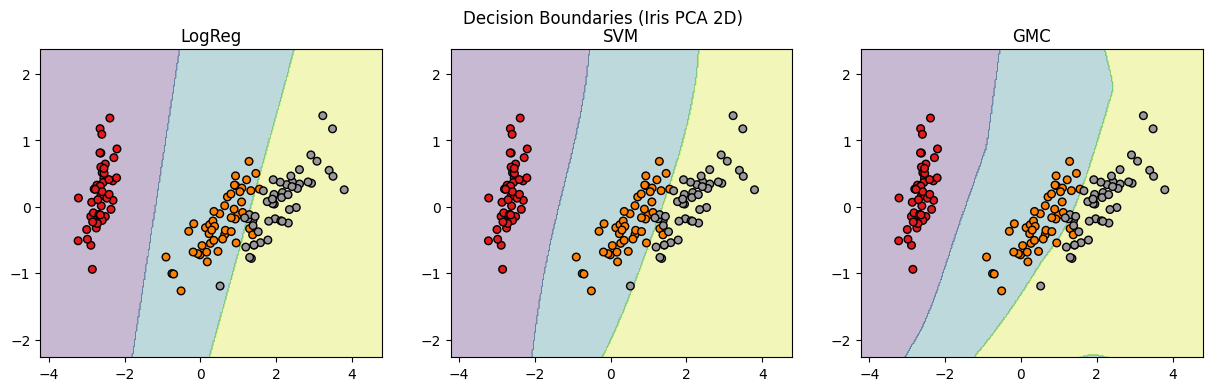

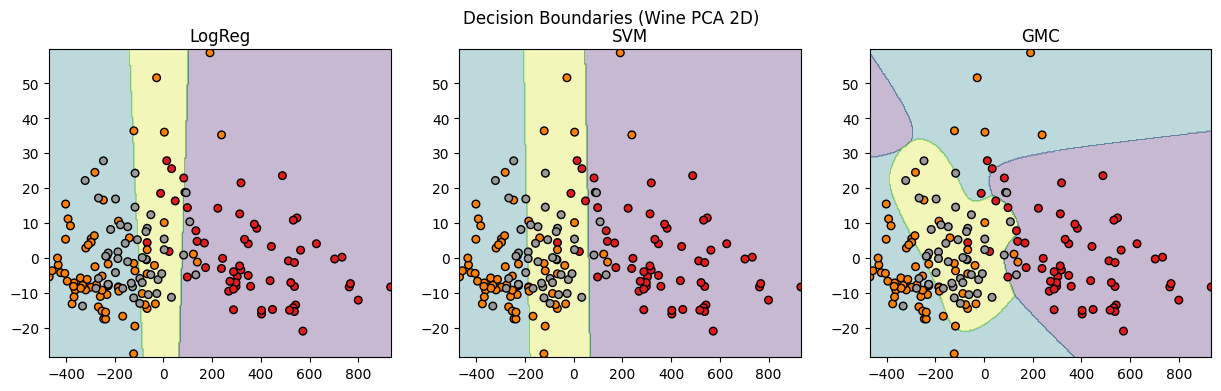

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

# --- Custom Gaussian Mixture Classifier (GMC) ---
class GMC:
    def __init__(self, n_components=1, covariance_type='full'):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for c in self.classes_:
            gmm = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type)
            gmm.fit(X[y == c])
            self.models[c] = gmm
        return self

    def predict_proba(self, X):
        likelihoods = []
        for c, gmm in self.models.items():
            likelihoods.append(np.exp(gmm.score_samples(X)))
        likelihoods = np.array(likelihoods).T
        probs = likelihoods / likelihoods.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

# --- Plot Decision Boundaries ---
def plot_boundaries(X, y, models, model_names, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    fig, axes = plt.subplots(1, len(models), figsize=(15, 4))

    for ax, model, name in zip(axes, models, model_names):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.3)
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor='k', cmap=plt.cm.Set1)
        ax.set_title(name)

    plt.suptitle(title)
    plt.show()

# --- Run for Dataset (Iris & Wine) ---
def run_dataset(dataset, title):
    X, y = dataset(return_X_y=True)
    X_pca = PCA(n_components=2).fit_transform(X)

    # Train models
    logreg = LogisticRegression(max_iter=500).fit(X_pca, y)
    svm = SVC(probability=True).fit(X_pca, y)
    gmc = GMC(n_components=2).fit(X_pca, y)  # allow more than 1 component per class

    # Plot decision regions
    plot_boundaries(X_pca, y, [logreg, svm, gmc], ["LogReg", "SVM", "GMC"], title)

# Run for Iris and Wine
run_dataset(load_iris, "Decision Boundaries (Iris PCA 2D)")
run_dataset(load_wine, "Decision Boundaries (Wine PCA 2D)")
